# Transfer Learning with MobileNetv2

In here we are going to train a pre-trained CNN to build an Alpaca Classifier. A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently; MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

So, let's import required classes to run the program.

In [1]:
# Required Lib's
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## Create Dataset and Split into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call image_data_set_from_directory() to read from the directory and create both training and validation datasets.

Specifying a validation split, we also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = 'dataset/'
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


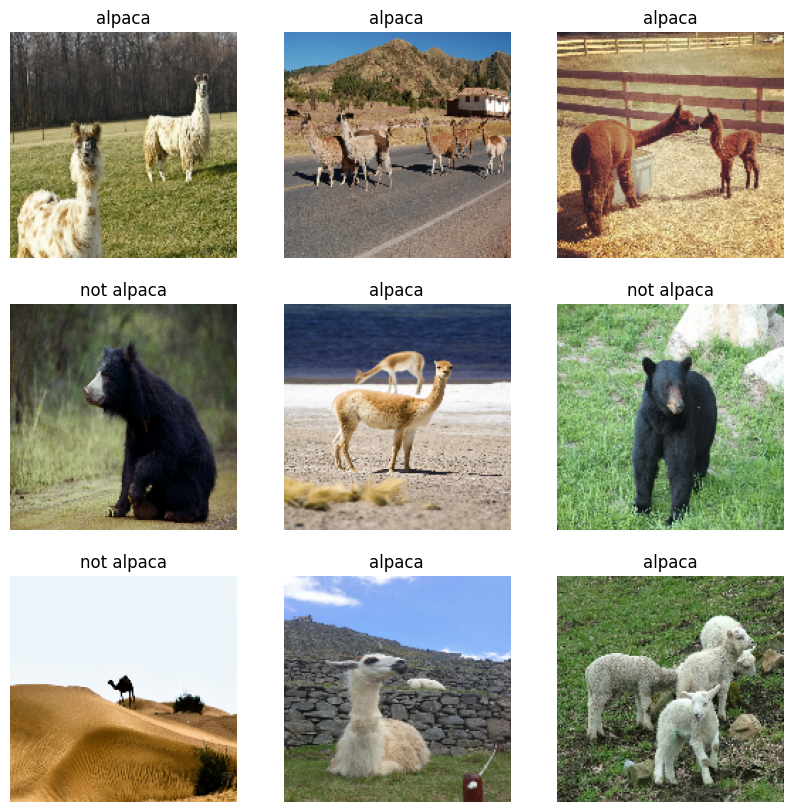

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess and Augment Training Data

`dataset.prefetch` in Tensorflow is an important data preprocessing step, it prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

We can set the number of elements to prefetch manually, or we can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help model learn the data better, it's standard practice augmenting the images by transforming them, i.e., randomly flipping and rotating them. Keras Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation
Function for data augmentation, We are going to use `RandomFlip` and `RandomRotation`

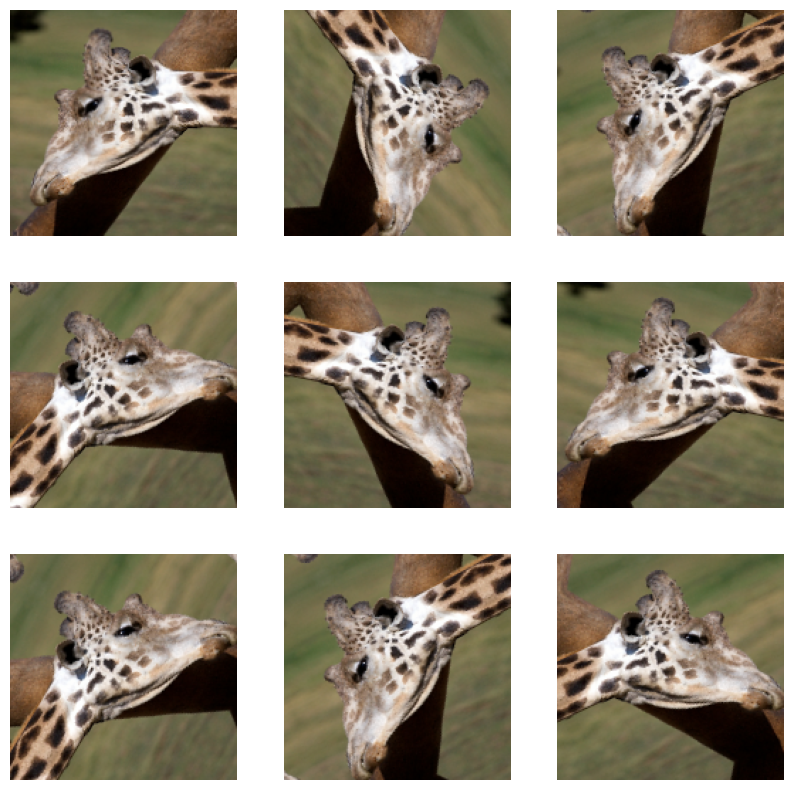

In [5]:
def data_augmenter():
    """
    Create a Sequential Model composed of 2 layers

    :return: tf.keras.Sequential
    """
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

# Checking on a single Example
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Our first tool from the MobileNet application in TensorFlow, to normalize input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice reusing that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

## Using MobileNetv2 for Transfer Learning

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottleneck layers

### Inside MobileNet Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

![Figure 1: MobileNetV2 Architecture](Images/mobilenetv2.png "Figure 1: MobileNetV2 Architecture")

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

Let's try to train our base model using all the layers from the pretrained model.

Similarly to how we reused the pretrained normalization values MobileNetV2 was trained on, we'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`.

In [6]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of our images.

In [7]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

Now decode the predictions made by the model. Earlier, when printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [8]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.4258216),
  ('n02708093', 'analog_clock', 0.09275691)],
 [('n04589890', 'window_screen', 0.23985802),
  ('n03887697', 'paper_towel', 0.1480276)],
 [('n04589890', 'window_screen', 0.7449467),
  ('n03598930', 'jigsaw_puzzle', 0.02194893)],
 [('n04589890', 'window_screen', 0.3354606),
  ('n03530642', 'honeycomb', 0.07628956)],
 [('n04589890', 'window_screen', 0.27327183),
  ('n03733281', 'maze', 0.08847052)],
 [('n04589890', 'window_screen', 0.67452615),
  ('n03530642', 'honeycomb', 0.07659936)],
 [('n04589890', 'window_screen', 0.7912853),
  ('n04209239', 'shower_curtain', 0.09241665)],
 [('n04589890', 'window_screen', 0.164631),
  ('n03598930', 'jigsaw_puzzle', 0.08749234)],
 [('n03598930', 'jigsaw_puzzle', 0.37021366),
  ('n04589890', 'window_screen', 0.09957031)],
 [('n04589890', 'window_screen', 0.616169),
  ('n03887697', 'paper_towel', 0.05487655)],
 [('n03530642', 'honeycomb', 0.25448704),
  ('n04589890', 'window_screen', 0.24874598)],
 [('n045898

There's a lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is a bunch of incorrectly classified images.

Fortunately, we can delete the top layer, which contains all the classification labels, and create a new classification layer.

### Layer Freezing and Functional API

1. Delete the top layer (the classification layer)
    - Set `include_top` in `base_model` as `False`
2. Add a new classifier layer
    - Train only one layer by freezing the rest of the network
    - As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    - Set `base model.trainable=False` to avoid changing the weights and train only the new layer
    - Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [9]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    """
    Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    """
    input_shape = image_shape + (3,)


    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # Freeze the base model by making it non-trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x)

    # set training to 'False' to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [10]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [12]:
# Setting Parameters and Training
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 7s 241ms/step - loss: 0.3928 - accuracy: 0.7977 - val_loss: 0.3002 - val_accuracy: 0.7692
Epoch 2/5
9/9 [==============================] - 2s 151ms/step - loss: 0.3517 - accuracy: 0.8168 - val_loss: 0.2120 - val_accuracy: 0.9231
Epoch 3/5
9/9 [==============================] - 2s 160ms/step - loss: 0.3078 - accuracy: 0.8855 - val_loss: 0.2218 - val_accuracy: 0.8154
Epoch 4/5
9/9 [==============================] - 2s 192ms/step - loss: 0.3390 - accuracy: 0.7939 - val_loss: 0.1985 - val_accuracy: 0.8923
Epoch 5/5
9/9 [==============================] - 2s 161ms/step - loss: 0.2679 - accuracy: 0.9084 - val_loss: 0.1687 - val_accuracy: 0.9385


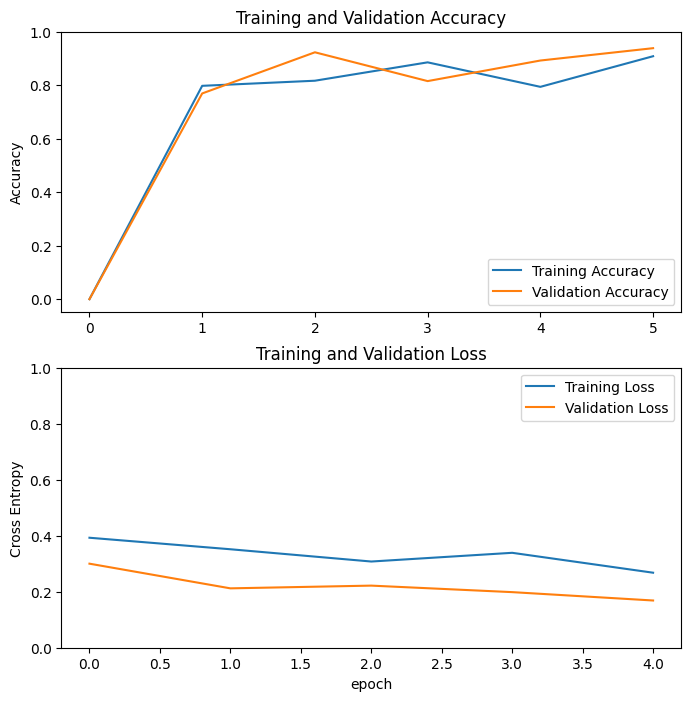

In [13]:
# Plot the training and validation accuracy:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine-Tuning Model

We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training model on the final layers with a very low learning rate. Adapting learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When we add new data, we generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to our data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if accuracy improved!

Number of layers in the base model:  154
Epoch 5/10
9/9 [==============================] - 2s 165ms/step - loss: 0.2635 - accuracy: 0.9046 - val_loss: 0.1674 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 2s 190ms/step - loss: 0.2859 - accuracy: 0.8511 - val_loss: 0.1711 - val_accuracy: 0.9077
Epoch 7/10
9/9 [==============================] - 2s 172ms/step - loss: 0.2881 - accuracy: 0.8435 - val_loss: 0.1387 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 2s 162ms/step - loss: 0.2122 - accuracy: 0.9389 - val_loss: 0.1311 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 2s 167ms/step - loss: 0.2449 - accuracy: 0.8931 - val_loss: 0.1577 - val_accuracy: 0.9077
Epoch 10/10
9/9 [==============================] - 2s 209ms/step - loss: 0.2269 - accuracy: 0.8702 - val_loss: 0.1317 - val_accuracy: 0.9385


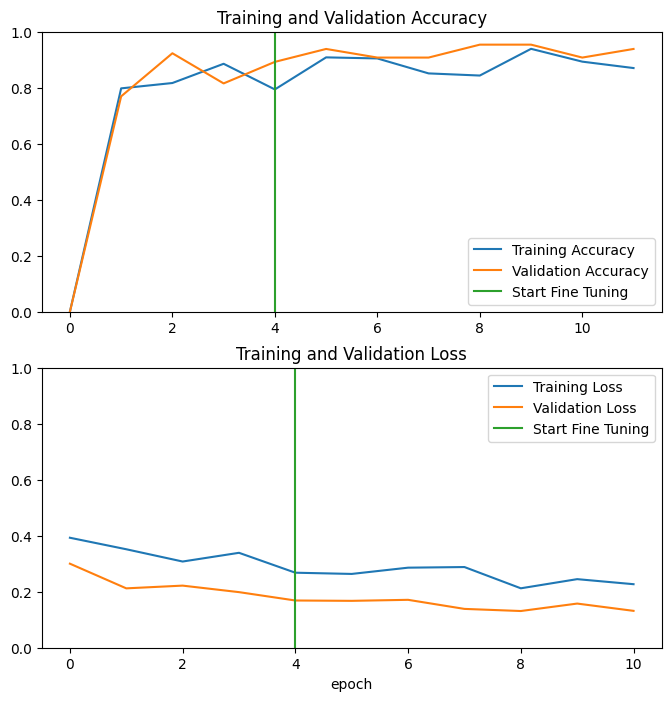

In [14]:
base_model = model2.layers[4]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.999, 
                                     epsilon=1e-07,
                                     amsgrad=False,
                                     name='Adam')

# Use accuracy as evaluation metric
metrics=['accuracy']

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()